cadCAD# cadCAD Tutorials: The Robot and the Marbles, part 1
## What is cadCAD?
cadCAD is a Python library that assists in the processes of designing, testing and validating complex systems through simulation. At its core, cadCAD is a differential games engine that supports parameter sweeping and Monte Carlo analyses and can be easily integrated with other scientific computing Python modules and data science workflows.

At [BlockScience](http://bit.ly/github_articles_M_1), we've been using cadCAD as a tool for [Token Engineering](https://medium.com/block-science/on-the-practice-of-token-engineering-part-i-c2cc2434e727) - the design of self-organizing systems enabled through cryptographic peer-to-peer networks. But cadCAD can simulate any system that can be described as state variables that evolve over time according to a set of equations. This series of articles will go over the basic concepts of cadCAD and the 'language' in which a system must be described in order for it to be interpretable by the library. This article will cover the following concepts:
* State Variables
* Timestep
* State Update Functions
* Partial State Update Blocks
* Simulation Configuration Parameters

To help illustrate, we'll refer to a simple example system

__The robot and the marbles__  
* Picture a box (`box_A`) with ten marbles in it; an empty box (`box_B`) next to the first one; and a robot arm capable of taking a marble from any one of the boxes and dropping it into the other one. 
* The robot is programmed to take one marble at a time from the box containing the largest number of marbles and drop it in the other box. It repeats that process until the boxes contain an equal number of marbles.  

## State Variables
>A state variable is one of the set of variables that are used to describe the mathematical "state" of a dynamical system. Intuitively, the state of a system describes enough about the system to determine its future behaviour in the absence of any external forces affecting the system. [_(source: Wikipedia)_](https://en.wikipedia.org/wiki/State_variable)

cadCAD can handle state variables of any Python data type, including custom classes. It is up to the user of cadCAD to determine the state variables needed to sufficiently accurately describe the system they are interested in.

We could describe the simple system in our example with only two state variables: the number of marbles in `box_A` and in `box_B`. These are not the only two variables that describe the system, of course. Things like the position of the robot arm in space or its temperature also qualify as "variables that describe the state of the system". But if we assume those variables have no impact on the behavior of the system (as implied by the description) we can safely disregard them.

cadCAD expects state variables to be passed to it as a Python `dict` where the `dict_keys` are the __names of the 
variables__ and the `dict_values` are their __initial values__.

In [1]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# List of all the state variables in the system and their initial values
genesis_states = {
    'box_A': 10, # as per the description of the example, box_A starts out with 10 marbles in it
    'box_B': 0 # as per the description of the example, box_B starts out empty
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Timestep
Computer simulations run in discrete time:
>Discrete time views values of variables as occurring at distinct, separate "points in time", or equivalently as being unchanged throughout each non-zero region of time ("time period")—that is, time is viewed as a discrete variable. Thus a non-time variable jumps from one value to another as time moves from one time period to the next. This view of time corresponds to a digital clock that gives a fixed reading of 10:37 for a while, and then jumps to a new fixed reading of 10:38, etc. [_(source: Wikipedia)_](https://en.wikipedia.org/wiki/Discrete_time_and_continuous_time)

The concept of Timestep in cadCAD refers to a discrete unit of time. cadCAD increments a "time counter", and at each step it updates the state variables according to the equations that describe the system. If time itself is a state variable that the user is interested in keeping track of, they may specify a state update function that models the passing of time. We'll cover that scenario in an upcoming article. For the moment, it suffices to define that the robot acts once per timestep.
# State Update Functions
State Update Functions are Python functions that represent the equations according to which the state variables change over time. Each state update function must return a tuple containing the name of the state variable being updated and its new value. The general structure of a state update function is:
```python
def function(params, step, sL, s, _input):
    ...
    y = ...
    x = ...
    return (y, x)
```
State update functions can read the current state of the system from argument `s`. We'll ignore the other arguments for now. `s` is a Python `dict` where the `dict_keys` are the __names of the variables__ and the `dict_values` are their __current values__. With this, we can define the state update functions for variables `box_A` and `box_B`.

In [2]:
def update_A(params, step, sH, s, _input):
    y = 'box_A'
    add_to_A = 0
    if (s['box_A'] > s['box_B']):
        add_to_A = -1
    elif (s['box_A'] < s['box_B']):
        add_to_A = 1
    x = s['box_A'] + add_to_A
    return (y, x)

def update_B(params, step, sH, s, _input):
    y = 'box_B'
    add_to_B = 0
    if (s['box_B'] > s['box_A']):
        add_to_B = -1
    elif (s['box_B'] < s['box_A']):
        add_to_B = 1
    x = s['box_B'] + add_to_B
    return (y, x)

# Partial State Update Blocks
Within a timestep, state update functions can be run in any combination of serial or parallel executions. Take the following diagram for example:
![partial state update blocks](partial-state-update-blocks.png "Partial State Update Blocks") <center><b>Figure 1: Visual representation of Partial State Update Blocks</b></center>

State update functions (SUF) 1 and 2 are run in parallel. This means that if SUF2 reads the value of variable A, it will not get the value updated by SUF1. On the other hand, SUF3 and SUF4 are executed after SUF1 and SUF2 have completed, thus having access to the updated values of variables A and C.

We refer to the groups of state update functions that are executed in parallel within a timestep as Partial State Update Blocks. cadCAD expects partial state update blocks to be specified as a list of `dict`s with the following structure:
```python
partial_state_update_blocks = [
    { 
        'policies': {
            'policy1': policy_function_1,
            'policy2': policy_function_2,
            ...
        },
        'variables': {
            'variable1': state_update_function_1,
            'variable2': state_update_function_2,
            ...
        }
    },
    ...
]
```

We'll ignore the `policies` key for now. The `dict` that represents the structure of Figure 1 would be:
```python
partial_state_update_blocks = [
    { 
        'policies': {
        },
        'variables': {
            'variableA': state_update_function_1,
            'variableC': state_update_function_2,
        }
    },
    { 
        'policies': {
        },
        'variables': {
            'variableA': state_update_function_3,
            'variableB': state_update_function_4,
        }
    }
]
```

In the case of our robot and marbles example system, we can model the system so that all state update functions are executed in parallel. In other words, we consider the marbles move from one box to the other simultaneously (ie, `box_A + box_B` is constant)

In [3]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, the user specifies if state update functions will be run in series or in parallel
partial_state_update_blocks = [
    { 
        'policies': { # We'll ignore policies for now
        },
        'variables': { # The following state variables will be updated simultaneously
            'box_A': update_A,
            'box_B': update_B
        }
    }
]
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Simulation Configuration Parameters
Lastly, we define the number of timesteps and the number of Monte Carlo runs of the simulation. These parameters must be passed in a dictionary, in `dict_keys` `T` and `N`, respectively. In our example, we'll run the simulation for 10 timesteps. And because we are dealing with a deterministic system, it makes no sense to have multiple Monte Carlo runs, so we set `N=1`. We'll ignore the `M` key for now and set it to an empty `dict`

In [4]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps
# We'll cover the `M` key in a future article. For now, let's omit it
sim_config_dict = {
    'T': range(10),
    'N': 1,
    #'M': {}
}
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

# Putting it all together
We have defined the state variables of our system and their initial conditions, as well as the state update functions, which have been grouped in a single state update block. We have also specified the parameters of the simulation (number of timesteps and runs). We are now ready to put all those pieces together in a `Configuration` object.

In [5]:
#imported some addition utilities to help with configuration set-up
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs

exp = Experiment()
c = config_sim(sim_config_dict)
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
del configs[:]
exp.append_configs(initial_state=genesis_states, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_configs=c #preprocessed dictionaries containing simulation parameters
                      )

# Running the engine
We are now ready to run the engine with the configuration defined above. Instantiate an ExecutionMode, an ExecutionContext and an Executor objects, passing the Configuration object to the latter. Then run the `execute()` method of the Executor object, which returns the results of the experiment in the first element of a tuple.

In [6]:
%%capture
from cadCAD.engine import ExecutionMode, ExecutionContext
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)

from cadCAD.engine import Executor

simulation = Executor(exec_context=local_mode_ctx, configs=exp.configs) # Pass the configuration object inside an array
raw_system_events, tensor_field, sessions = simulation.execute() # The `execute()` method returns a tuple; its first elements contains the raw results

# Analyzing the results
We can now convert the raw results into a DataFrame for analysis

In [7]:
%matplotlib inline
import pandas as pd
simulation_result = pd.DataFrame(raw_system_events)
simulation_result.set_index(['subset', 'run', 'timestep', 'substep'])

box_A  box_B  simulation
subset run timestep substep                          
0      1   0        0           10      0           0
           1        1            9      1           0
           2        1            8      2           0
           3        1            7      3           0
           4        1            6      4           0
           5        1            5      5           0
           6        1            5      5           0
           7        1            5      5           0
           8        1            5      5           0
           9        1            5      5           0
           10       1            5      5           0

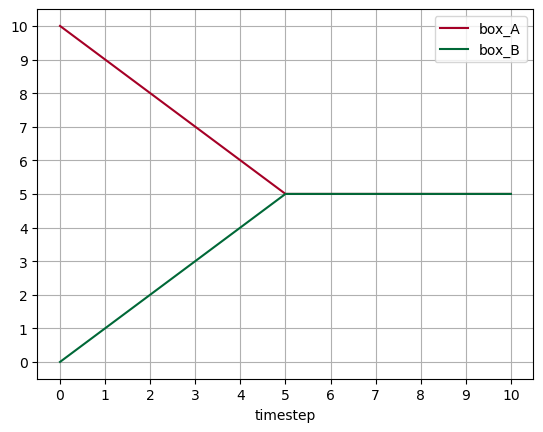

In [8]:
simulation_result.plot('timestep', ['box_A', 'box_B'], grid=True, 
        colormap = 'RdYlGn',
        xticks=list(simulation_result['timestep'].drop_duplicates()), 
        yticks=list(range(1+(simulation_result['box_A']+simulation_result['box_B']).max())));

Because the number of marbles in the system is even, it converges to an equilibrium with 5 marbles in each box. Simulating a scenario with an odd number of marbles is as easy as modifying the `initial_condition` of the system, recreating the configuration object and rerunning the simulation:

In [9]:
%%capture
genesis_states = {
    'box_A': 11,
    'box_B': 0
}

del exp.configs[:]
exp.append_configs(initial_state=genesis_states, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_configs=c #preprocessed dictionaries containing simulation parameters
                      )

raw_result, tensor, sessions = simulation.execute()

In [10]:
simulation_result = pd.DataFrame(raw_result)
simulation_result.set_index(['simulation', 'run', 'timestep', 'substep'])

box_A  box_B  subset
simulation run timestep substep                      
1          1   0        0           11      0       0
               1        1           10      1       0
               2        1            9      2       0
               3        1            8      3       0
               4        1            7      4       0
               5        1            6      5       0
               6        1            5      6       0
               7        1            6      5       0
               8        1            5      6       0
               9        1            6      5       0
               10       1            5      6       0

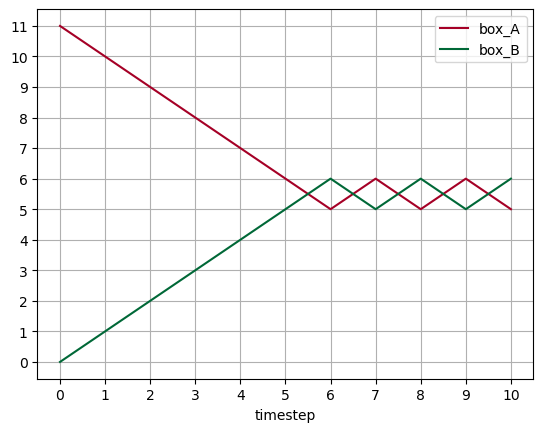

In [11]:
simulation_result.plot('timestep', ['box_A', 'box_B'], grid=True, 
        colormap = 'RdYlGn',
        xticks=list(simulation_result['timestep'].drop_duplicates()), 
        yticks=list(range(1+(simulation_result['box_A']+simulation_result['box_B']).max())));

As was to be expected, the system oscilates between 5 and 6 marbles in each box.

In the next article of this series we'll cover another base concept in cadCAD: **policies**.

---

_About BlockScience_  
[BlockScience](http://bit.ly/github_articles_M_1) is a research and engineering firm specialized in complex adaptive systems and applying practical methodologies from engineering design, development and testing to projects in emerging technologies such as blockchain. Follow us on [Medium](http://bit.ly/bsci-medium) or [Twitter](http://bit.ly/bsci-twitter) to stay in touch.